**NAME** : Peethala Navya



**ENROLMENT NUMBER** : 221020445 

----

**Importing MNIST datasets from tensorflow**

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


**Defining function which can add noise to the dataset**

In [5]:
def add_gaussian_noise(images, mean=0.0, stddev=0.5):
    noise = np.random.normal(mean, stddev, images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0., 1.)

def add_salt_and_pepper_noise(images, salt_prob=0.1, pepper_prob=0.1):
    noisy_images = np.copy(images)
    salt = np.random.choice([0, 1], size=images.shape, p=[1 - salt_prob, salt_prob])
    pepper = np.random.choice([0, 1], size=images.shape, p=[1 - pepper_prob, pepper_prob])
    noisy_images[salt == 1] = 1.0
    noisy_images[pepper == 1] = 0.0
    return noisy_images

def add_patchwise_noise(images, num_patches=10, patch_size=(5, 5)):
    noisy_images = np.copy(images)
    for img in noisy_images:
        for _ in range(num_patches):
            x = np.random.randint(0, img.shape[0] - patch_size[0])
            y = np.random.randint(0, img.shape[1] - patch_size[1])
            img[x:x+patch_size[0], y:y+patch_size[1], :] = np.random.choice([0, 1])
    return noisy_images

**Adding gaussuian noise to the training and testing dataset**

In [6]:
gaussian_noisy_train = add_gaussian_noise(x_train)
gaussian_noisy_test = add_gaussian_noise(x_test)

**Adding salt and pepper noise to the training and testing dataset**

In [7]:
salt_and_pepper_noisy_train = add_salt_and_pepper_noise(x_train)
salt_and_pepper_noisy_test = add_salt_and_pepper_noise(x_test)

**Adding patchwise noise to the training and testing dataset**

In [8]:
patchwise_noisy_train = add_patchwise_noise(x_train)
patchwise_noisy_test = add_patchwise_noise(x_test)

**Building Autoencoder**

In [9]:
from tensorflow.keras import layers, models

def build_encoder():
    encoder = models.Sequential()
    encoder.add(layers.Input(shape=(28, 28, 1)))
    encoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    encoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    encoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    return encoder

def build_decoder():
    decoder = models.Sequential()
    decoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.UpSampling2D((2, 2)))
    decoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.UpSampling2D((2, 2)))
    decoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    decoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return decoder

encoder = build_encoder()
decoder = build_decoder()
autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


**Training and testing**

In [10]:
autoencoder.fit(gaussian_noisy_train, x_train, epochs=10, batch_size=128, validation_data=(gaussian_noisy_test, x_test))

Epoch 1/10


2024-08-26 09:27:36.970420: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-08-26 09:27:37.022010: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


469/469 ━━━━━━━━━━━━━━━━━━━━ 213s 449ms/step - loss: 0.2136 - val_loss: 0.1048
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 260s 448ms/step - loss: 0.1045 - val_loss: 0.0999
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 448ms/step - loss: 0.1000 - val_loss: 0.0979
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 210s 447ms/step - loss: 0.0976 - val_loss: 0.0961
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 447ms/step - loss: 0.0961 - val_loss: 0.0951
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 446ms/step - loss: 0.0951 - val_loss: 0.0939
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 446ms/step - loss: 0.0945 - val_loss: 0.0933
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 446ms/step - loss: 0.0937 - val_loss: 0.0926
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 444ms/step - loss: 0.0930 - val_loss: 0.0926
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 209s 446ms/step - loss: 0.0925 - val_loss: 0.0921


**Visualizing the data of gausian noise and denoised image**

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


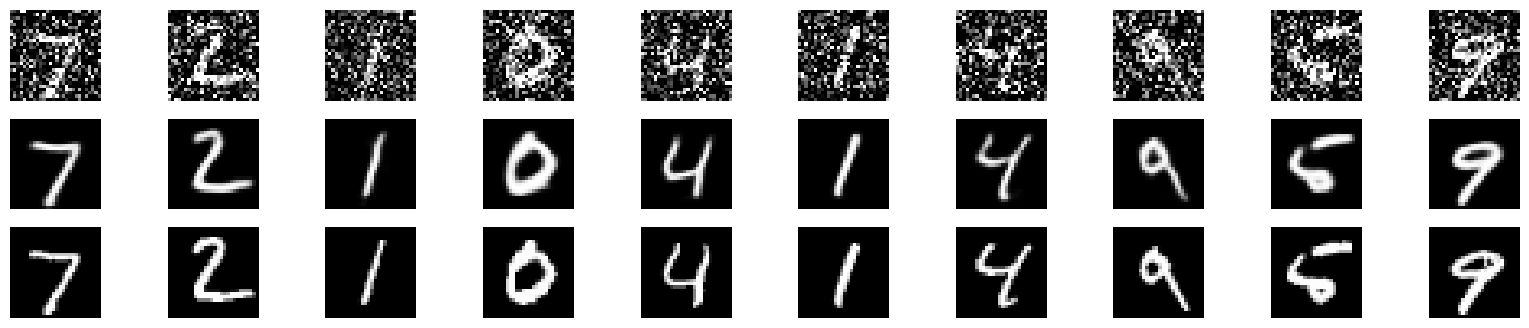

In [11]:
import matplotlib.pyplot as plt

# Visualize some results
def display_images(noisy, denoised, original, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display noisy images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Display denoised images
        ax = plt.subplot(3, num_images, i + num_images + 1)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Display original images
        ax = plt.subplot(3, num_images, i + 2*num_images + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Get denoised images
denoised_images = autoencoder.predict(gaussian_noisy_test)

# Display comparison
display_images(gaussian_noisy_test, denoised_images, x_test)

**Visualizing the data of salt & pepper noise and denoised image**

In [12]:
autoencoder.fit(salt_and_pepper_noisy_train, x_train, epochs=10, batch_size=128, validation_data=(salt_and_pepper_noisy_test, x_test))

Epoch 1/10


2024-08-26 10:09:46.853422: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-08-26 10:09:46.901549: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 441ms/step - loss: 0.0816 - val_loss: 0.0782
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 442ms/step - loss: 0.0782 - val_loss: 0.0761
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 440ms/step - loss: 0.0762 - val_loss: 0.0748
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 441ms/step - loss: 0.0748 - val_loss: 0.0738
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 441ms/step - loss: 0.0735 - val_loss: 0.0729
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 438ms/step - loss: 0.0729 - val_loss: 0.0720
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 207s 442ms/step - loss: 0.0723 - val_loss: 0.0715
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 442ms/step - loss: 0.0717 - val_loss: 0.0711
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 441ms/step - loss: 0.0711 - val_loss: 0.0704
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 441ms/step - loss: 0.0707 - val_loss: 0.0701


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


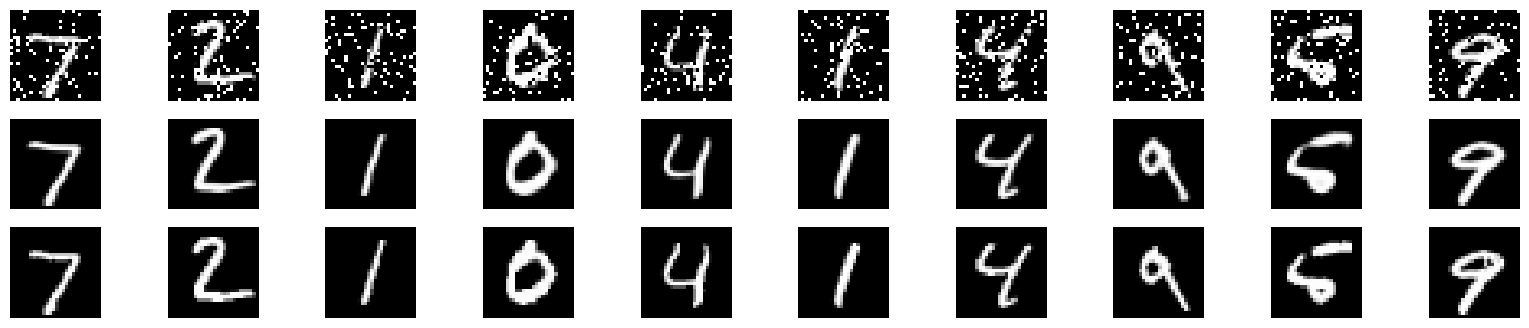

In [13]:
import matplotlib.pyplot as plt

# Visualize some results
def display_images(noisy, denoised, original, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display noisy images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Display denoised images
        ax = plt.subplot(3, num_images, i + num_images + 1)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Display original images
        ax = plt.subplot(3, num_images, i + 2*num_images + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Get denoised images
denoised_images = autoencoder.predict(salt_and_pepper_noisy_test)

# Display comparison
display_images(salt_and_pepper_noisy_test, denoised_images, x_test)

**Visualizing the data of patchwise noise and denoised image**

In [14]:
autoencoder.fit(patchwise_noisy_train, x_train, epochs=10, batch_size=128, validation_data=(patchwise_noisy_test, x_test))

2024-08-26 10:49:00.164685: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 206s 439ms/step - loss: 0.2008 - val_loss: 0.1263
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 440ms/step - loss: 0.1228 - val_loss: 0.1159
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 439ms/step - loss: 0.1157 - val_loss: 0.1118
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 438ms/step - loss: 0.1118 - val_loss: 0.1103
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 438ms/step - loss: 0.1093 - val_loss: 0.1076
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 439ms/step - loss: 0.1068 - val_loss: 0.1056
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 437ms/step - loss: 0.1055 - val_loss: 0.1035
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 437ms/step - loss: 0.1039 - val_loss: 0.1027
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 206s 439ms/step - loss: 0.1027 - val_loss: 0.1025
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 436ms/step - loss: 0.1021 - val_loss: 0.1009


313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step


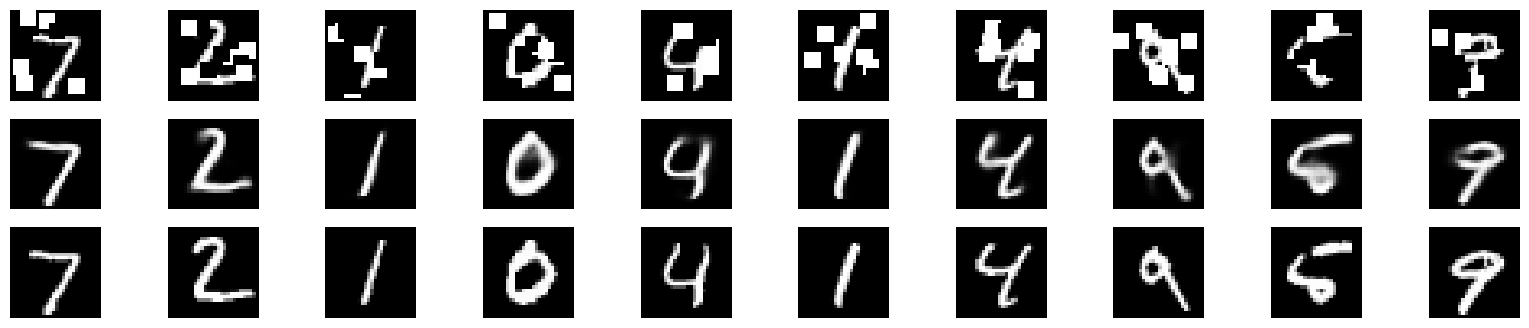

In [15]:
import matplotlib.pyplot as plt

# Visualize some results
def display_images(noisy, denoised, original, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Display noisy images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Display denoised images
        ax = plt.subplot(3, num_images, i + num_images + 1)
        plt.imshow(denoised[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Display original images
        ax = plt.subplot(3, num_images, i + 2*num_images + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Get denoised images
denoised_images = autoencoder.predict(patchwise_noisy_test)

# Display comparison
display_images(patchwise_noisy_test, denoised_images, x_test)